In [1]:
import pandas as pd
import numpy as np
import librosa
import warnings
import tensorflow as tf 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    LSTM,
    Bidirectional,
    Dropout,
    BatchNormalization,
    Dense,
    MaxPooling1D,
    Flatten,
)
import os 
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.models import save_model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
np.random.seed(42) # Setting random seed for numpy to ensure reproducibility
tf.random.set_seed(42) # Setting random seed for TensorFlow to ensure reproducibility

In [2]:
real_audio_dir = r"C:\Users\asus2022\OneDrive - New Ismailia National University\Documents\for-norm\training\real"
fake_audio_dir = r"C:\Users\asus2022\OneDrive - New Ismailia National University\Documents\for-norm\training\fake"

print("real exists:", os.path.exists(real_audio_dir))
print("is dir:", os.path.isdir(real_audio_dir))

print("fake exists:", os.path.exists(fake_audio_dir))
print("is dir:", os.path.isdir(fake_audio_dir))

real exists: True
is dir: True
fake exists: True
is dir: True


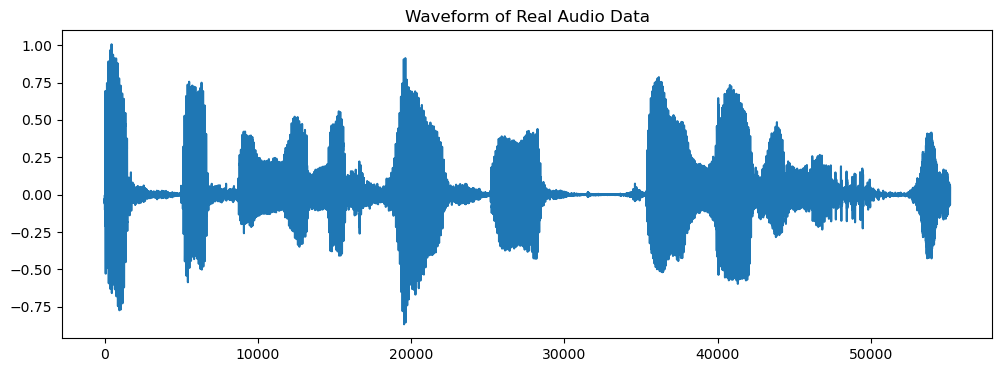

In [3]:
# First Sample 
files_r = [f for f in os.listdir(real_audio_dir) if f.endswith(".wav") or f.endswith(".mp3")]
real_audio_file = os.path.join(real_audio_dir, files_r[0])  # أول ملف

# Load file
real_ad, real_sr = librosa.load(real_audio_file)

# GRAPH
plt.figure(figsize=(12, 4))
plt.plot(real_ad)
plt.title("Waveform of Real Audio Data")
plt.savefig('fig1.png', dpi=300, bbox_inches='tight')
plt.show()


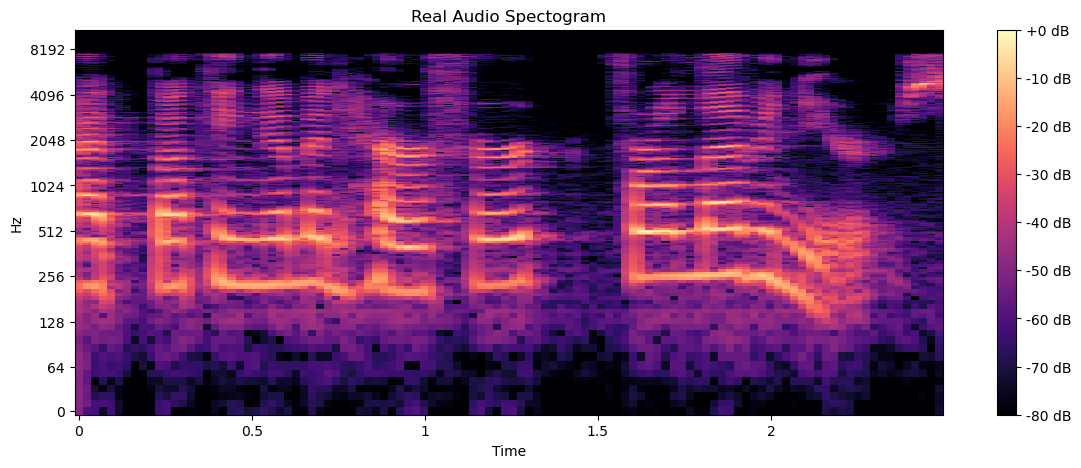

In [4]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.savefig('fig2.png', dpi=300, bbox_inches='tight')
plt.show()

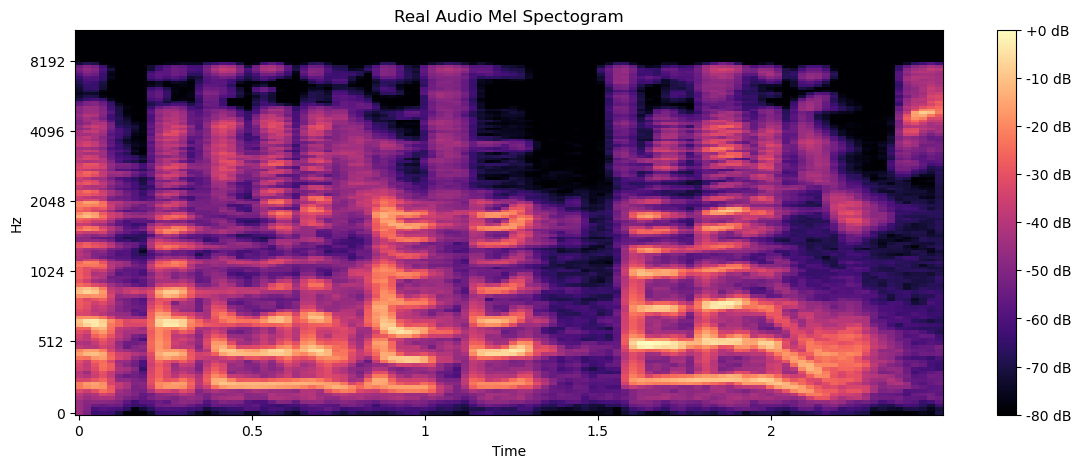

In [5]:
real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time")
plt.title("Real Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.savefig('fig3.png', dpi=300, bbox_inches='tight')
plt.show()

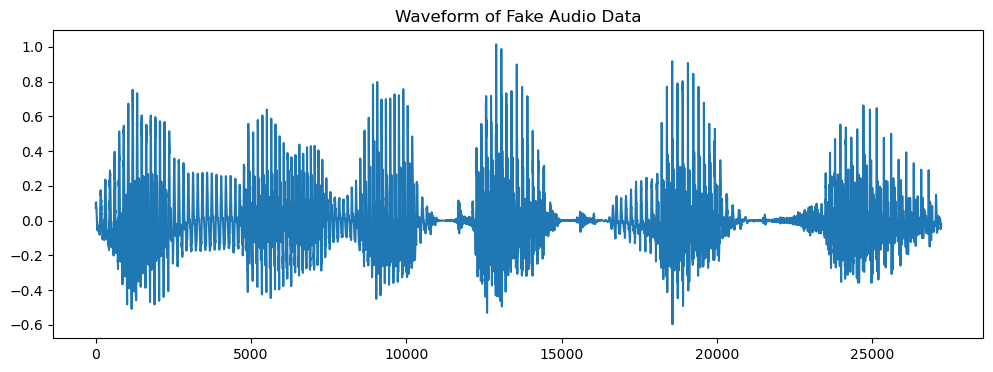

In [6]:
files_f = [f for f in os.listdir(fake_audio_dir) if f.endswith(".wav") or f.endswith(".mp3")]
fake_audio_file = os.path.join(fake_audio_dir, files_f[0])  # 
# Load file
fake_ad, fake_sr = librosa.load(fake_audio_file)

# Graph
plt.figure(figsize=(12, 4))
plt.plot(fake_ad)
plt.title("Waveform of Fake Audio Data")
plt.savefig('fig1.png', dpi=300, bbox_inches='tight')
plt.show()

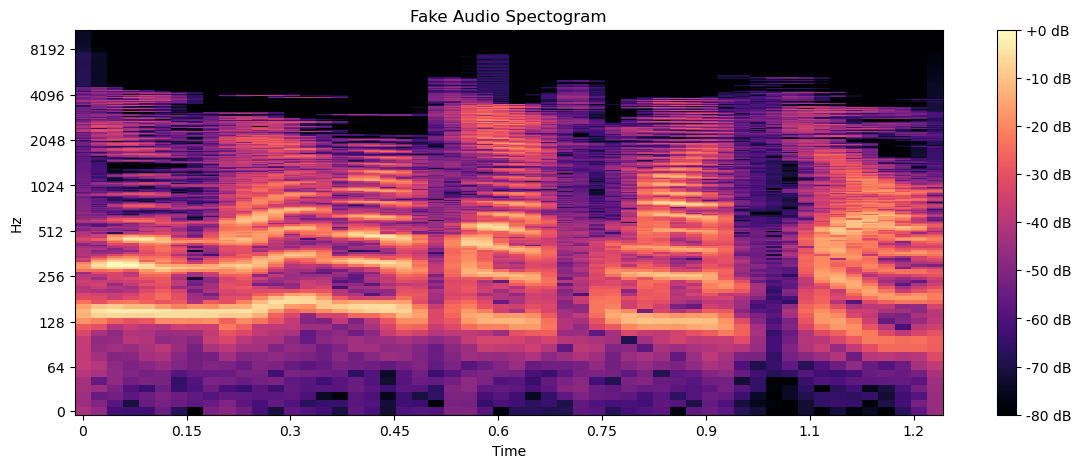

In [7]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectogram")
plt.savefig('fig5.png', dpi=300, bbox_inches='tight')
plt.show()

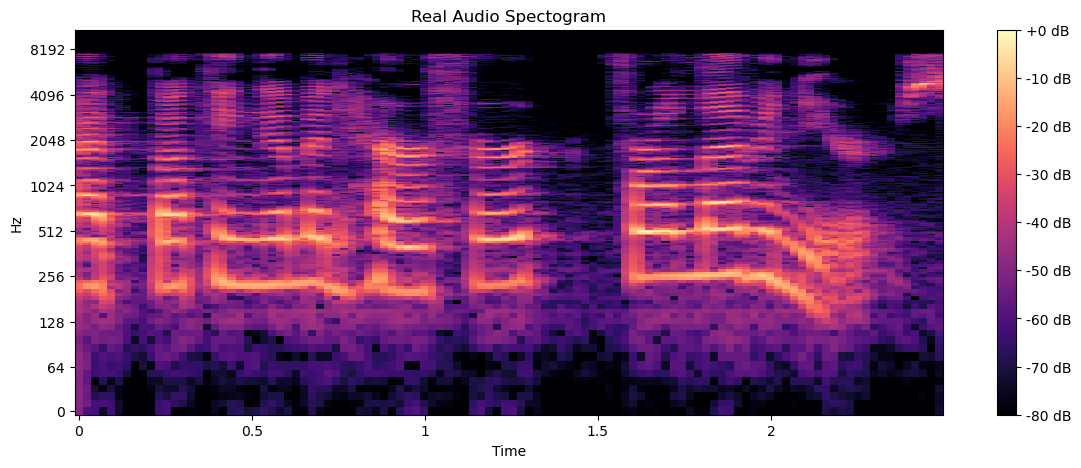

In [8]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.savefig('fig2.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
real_audio_dir = r"C:\Users\asus2022\OneDrive - New Ismailia National University\Documents\for-norm\training\real"
fake_audio_dir = r"C:\Users\asus2022\OneDrive - New Ismailia National University\Documents\for-norm\training\fake"
# Extract the features 
def extract_audio_features(file_path, target_length=5, sr=22050, n_mfcc=20):
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=sr, duration=target_length)

        # Padding or trimming
        if len(y) < target_length * sr:
            y = np.pad(y, (0, max(0, target_length * sr - len(y))), mode='constant')
        else:
            y = y[:target_length * sr]
        
        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        
        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        
        # Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        
        # Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        
        # Spectral Roll-off
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        
        # Zero Crossing Rate (ZCR)
        zcr = librosa.feature.zero_crossing_rate(y)
        
        # RMS (Root Mean Square Energy)
        rms = librosa.feature.rms(y=y)
        
        # Tonnetz (Musical feature)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

        # Combine all features into one
        features = np.vstack([mfcc, chroma, spectral_centroid, spectral_bandwidth, spectral_rolloff, zcr, rms, tonnetz])
        
        return features.T  # Transpose to (timesteps, features)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def process_sequence_directory(directory, label, target_length=5):
    data = []
    labels = []
    files = [f for f in os.listdir(directory) if f.endswith(('.wav', '.mp3'))]

    for filename in tqdm(files, desc=f"Processing {label} files"):
        file_path = os.path.join(directory, filename)
        feature_sequence = extract_audio_features(file_path, target_length)
        
        if feature_sequence is not None:
            data.append(feature_sequence)
            labels.append(label)
    
    return data, labels


def load_and_prepare_sequences(real_dir, fake_dir, target_length=5):
    real_data, real_labels = process_sequence_directory(real_dir, "REAL", target_length)
    fake_data, fake_labels = process_sequence_directory(fake_dir, "FAKE", target_length)

    # Balance the classes
    min_len = min(len(real_data), len(fake_data))
    real_data, real_labels = real_data[:min_len], real_labels[:min_len]
    fake_data, fake_labels = fake_data[:min_len], fake_labels[:min_len]

    all_data = real_data + fake_data
    all_labels = real_labels + fake_labels

    # Convert to numpy
    X = np.array(all_data)
    y = np.array([1 if lbl == 'REAL' else 0 for lbl in all_labels])

    # Reshape X to fit LSTM/CNN (samples, timesteps, features)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])  # Add this reshaping step if necessary

    return X, y

X, y = load_and_prepare_sequences(real_audio_dir, fake_audio_dir)

Processing REAL files:   0%|          | 0/26941 [00:00<?, ?it/s]

C:\Users\asus2022\OneDrive - New Ismailia National University\Documents\Anaconda\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Processing FAKE files:   0%|          | 0/26927 [00:00<?, ?it/s]

In [ ]:

# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Model  
model = Sequential()

#  Conv1D
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X.shape[1], X.shape[2])))      
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))  

#  LSTM
model.add(Bidirectional(LSTM(128, return_sequences=True)))    
model.add(Dropout(0.4))

model.add(Bidirectional(LSTM(64)))  
model.add(Dropout(0.4))

# طبقات Dense
model.add(Dense(128, activation='relu'))      
model.add(Dropout(0.5))  
model.add(Dense(1, activation='sigmoid'))  

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training 
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=64, callbacks=[early_stop])


In [ ]:
# Save Model 
model.save('mano2.h5')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediction
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Prediction as ( 1 OR 0 )

#  (Classification Report)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

# (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred_binary)

#  heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [2]:
import gradio as gr
import librosa
import numpy as np
from tensorflow.keras.models import load_model

# Load Model 
model = load_model('mano.h5')

def extract_audio_features(file_path, target_length=5, sr=22050, n_mfcc=20):
    try:
        # Load Voice 
        y, sr = librosa.load(file_path, sr=sr, duration=target_length)

        # Padding or trimming
        if len(y) < target_length * sr:
            y = np.pad(y, (0, max(0, target_length * sr - len(y))), mode='constant')
        else:
            y = y[:target_length * sr]
        
        # Extract Feature 
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        rms = librosa.feature.rms(y=y)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

        # merge Feature
        features = np.vstack([mfcc, chroma, spectral_centroid, spectral_bandwidth, spectral_rolloff, zcr, rms, tonnetz])
        
        return features.T  # العودة على شكل (timesteps, features)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def predict_audio(file):
    # Extract Feature
    features = extract_audio_features(file)
    
    if features is not None:
        # Reshaped to be similer to data trainer (samples, timesteps, features)
        features = features.reshape(1, features.shape[0], features.shape[1])
        
        # Predict
        prediction = model.predict(features)
        
        # The result
        return "Real" if prediction[0] > 0.5 else "Fake"
    else:
        return "Error processing audio file."

# Gradio ( UI )
iface = gr.Interface(
    fn=predict_audio, 
    inputs=gr.Audio(type="filepath", label="Upload Audio"),
    outputs=gr.Textbox(label="Prediction (Real/Fake)"),
    title="Deepfake Audio Detection",
    description="Upload an audio file to predict whether it is real or fake."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
